In [24]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
# import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

# from fbprophet import Prophet
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
import xgboost as xgb
from datetime import timedelta
import warnings
warnings.filterwarnings(action='ignore')

In [25]:
modelling_data = pd.read_parquet("modelling_data.parquet")
#inspecting the head
modelling_data.head()

,facility_id,facility_name,capacity,occupancy,longitude,latitude,parking_availability,day_of_week,time_category,month,is_holiday,datetime
0,6,Gordon Henry St North Car Park,213,31,-33.756009,151.154528,182,Saturday,Night,July,No,2023-07-01 00:01:02
1,6,Gordon Henry St North Car Park,213,30,-33.756009,151.154528,183,Saturday,Night,July,No,2023-07-01 00:21:32
2,6,Gordon Henry St North Car Park,213,31,-33.756009,151.154528,182,Saturday,Early Morning,July,No,2023-07-01 05:36:31
3,6,Gordon Henry St North Car Park,213,32,-33.756009,151.154528,181,Saturday,Early Morning,July,No,2023-07-01 05:51:02
4,6,Gordon Henry St North Car Park,213,33,-33.756009,151.154528,180,Saturday,Morning,July,No,2023-07-01 07:03:16


XGBOOST MODEL

In [63]:
xg_dummies = pd.get_dummies(modelling_data[['day_of_week', 'time_category', 'month', 'is_holiday']],
                            columns=["day_of_week", "time_category", 'month', 'is_holiday'], prefix= ["day_of_the_week", "time_period", 'month', 'is_holiday'],
                            sparse= False, drop_first= True)
#converting dummies to numerical
xg_dummies = xg_dummies.astype(int)
#joining the dummies and original df
xg_encoded = pd.concat( [modelling_data, xg_dummies] ,axis=1)
#dropping cat columns
xg_encoded.drop(["longitude", "latitude", "occupancy", "facility_name", "month", "time_category", "day_of_week", "is_holiday"], axis= 1, inplace= True)

xg_encoded = xg_encoded.set_index("datetime")

In [64]:
xg_grouped = xg_encoded.groupby("facility_id")
xg_grouped.head(20)

,facility_id,capacity,parking_availability,day_of_the_week_Monday,day_of_the_week_Saturday,day_of_the_week_Sunday,day_of_the_week_Thursday,day_of_the_week_Tuesday,day_of_the_week_Wednesday,time_period_Early Morning,time_period_Evening,time_period_Late Afternoon,time_period_Morning,time_period_Night,month_December,month_July,month_November,month_October,month_September,is_holiday_Yes
datetime,,,,,,,,,,,,,,,,,,,,
2023-07-01 00:01:02,6,213,182,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2023-07-01 00:21:32,6,213,183,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2023-07-01 05:36:31,6,213,182,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2023-07-01 05:51:02,6,213,181,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2023-07-01 07:03:16,6,213,180,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 02:10:24,25,145,137,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2023-07-01 02:20:25,25,145,137,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2023-07-01 02:30:27,25,145,137,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


Mean Squared Error for 6: 1058.7133849664694
Root Mean Squared Error for 6: 32.53787615943102
Mean Absolute Error for 6: 25.57143409526432


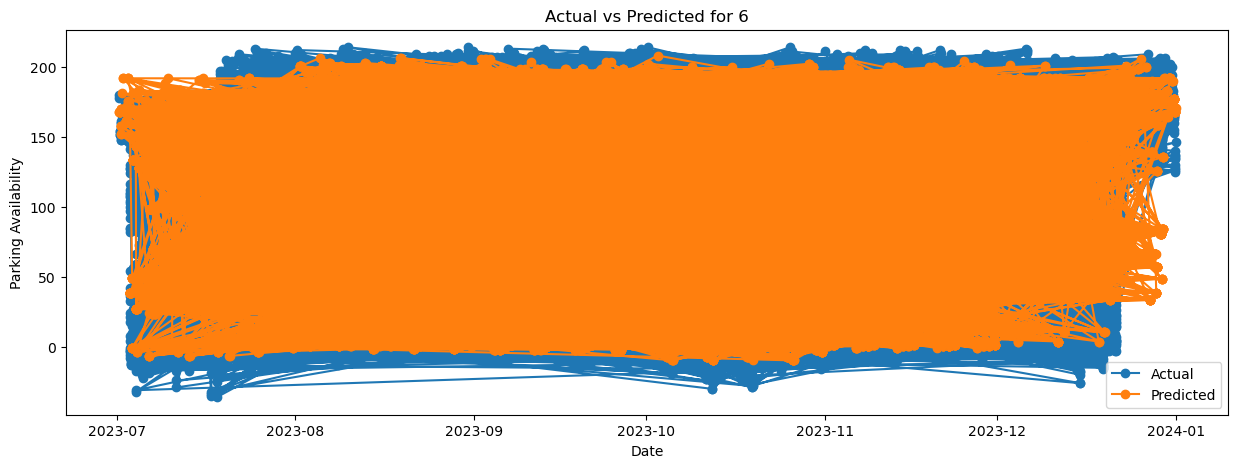

Mean Squared Error for 7: 30.612947634922307
Root Mean Squared Error for 7: 5.532896857426705
Mean Absolute Error for 7: 3.885813878642188


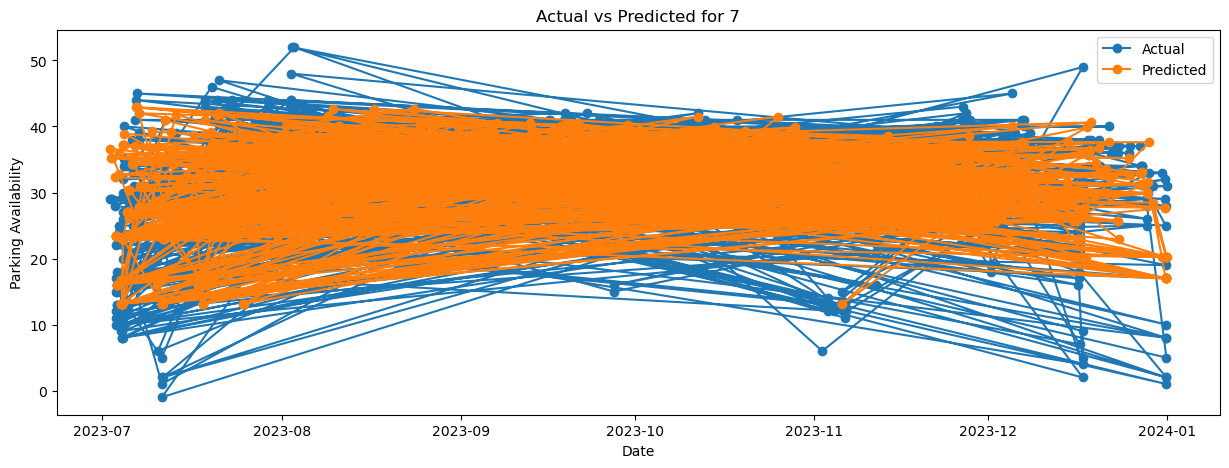

Mean Squared Error for 8: 14073.556665521264
Root Mean Squared Error for 8: 118.63202209151315
Mean Absolute Error for 8: 93.31722712803652


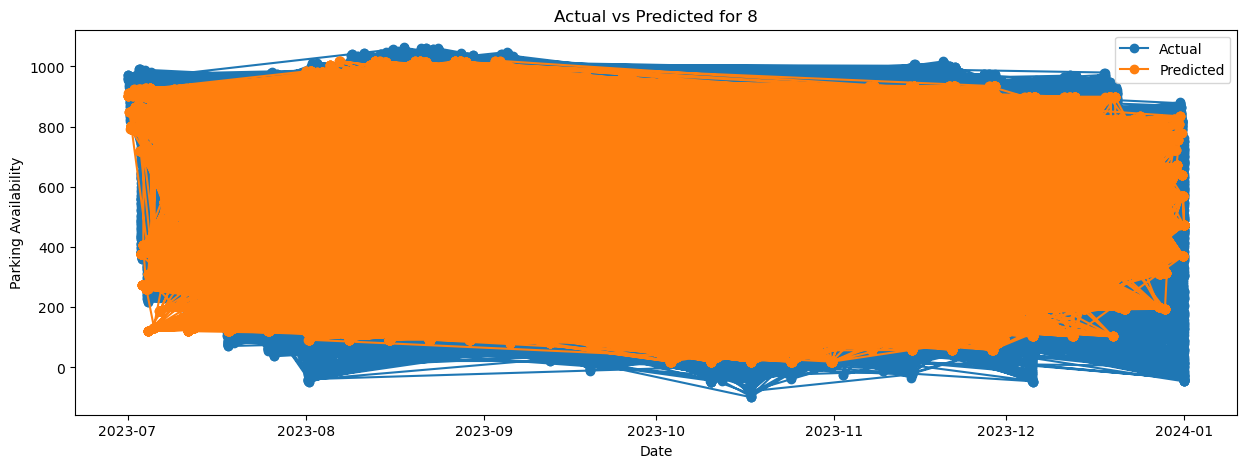

Mean Squared Error for 9: 7090.257429977423
Root Mean Squared Error for 9: 84.20366636897364
Mean Absolute Error for 9: 62.861395546841145


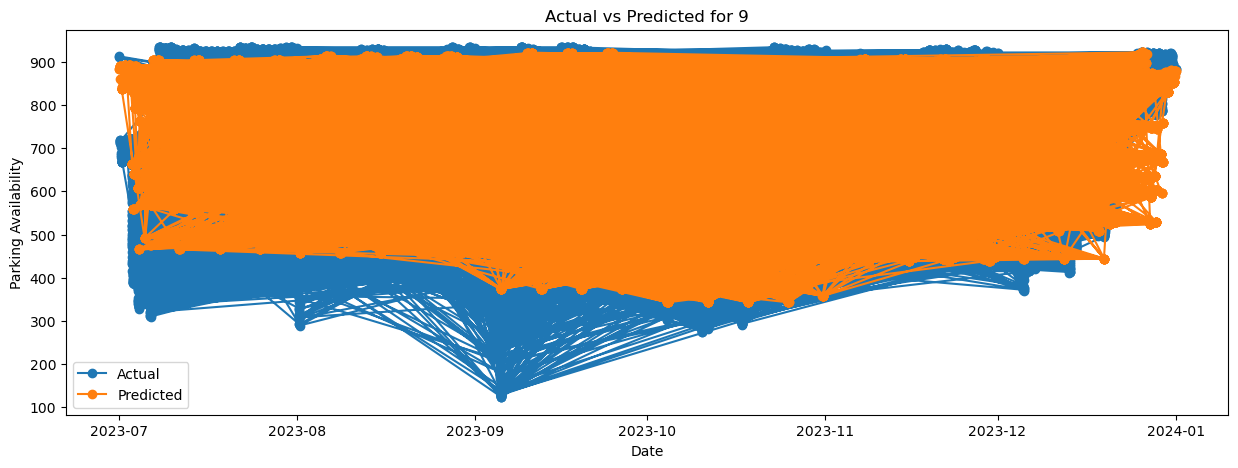

Mean Squared Error for 10: 1659.5863922242952
Root Mean Squared Error for 10: 40.7380214569178
Mean Absolute Error for 10: 30.749197186032347


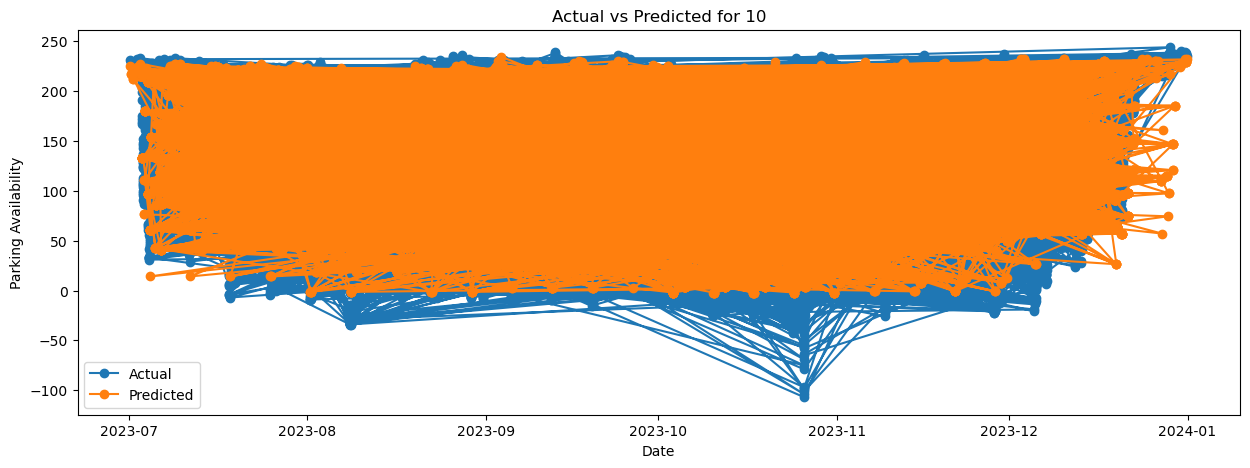

Mean Squared Error for 11: 35.96299570773971
Root Mean Squared Error for 11: 5.996915516141586
Mean Absolute Error for 11: 4.51706037309088


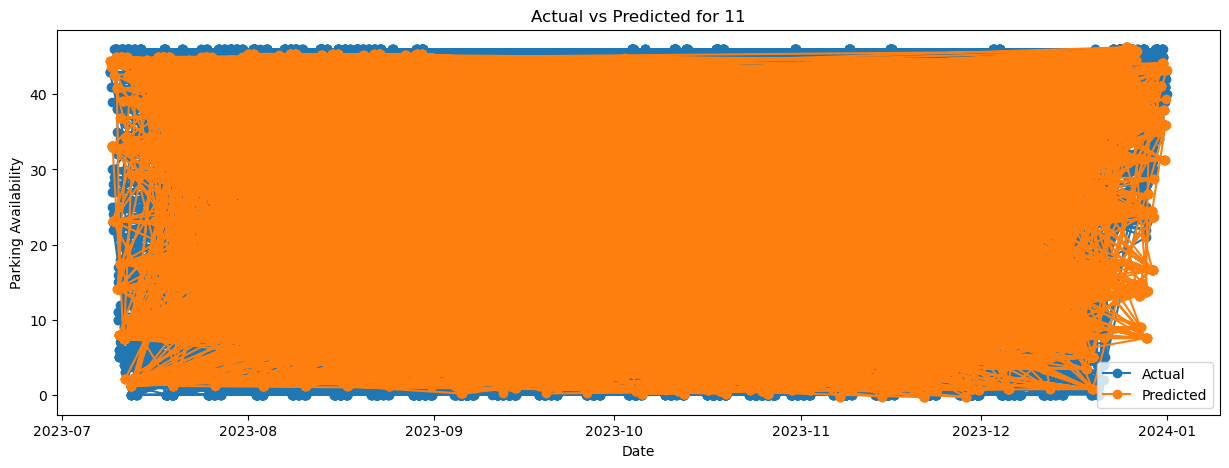

Mean Squared Error for 12: 139.04519717872896
Root Mean Squared Error for 12: 11.791742754094026
Mean Absolute Error for 12: 8.694661154299896


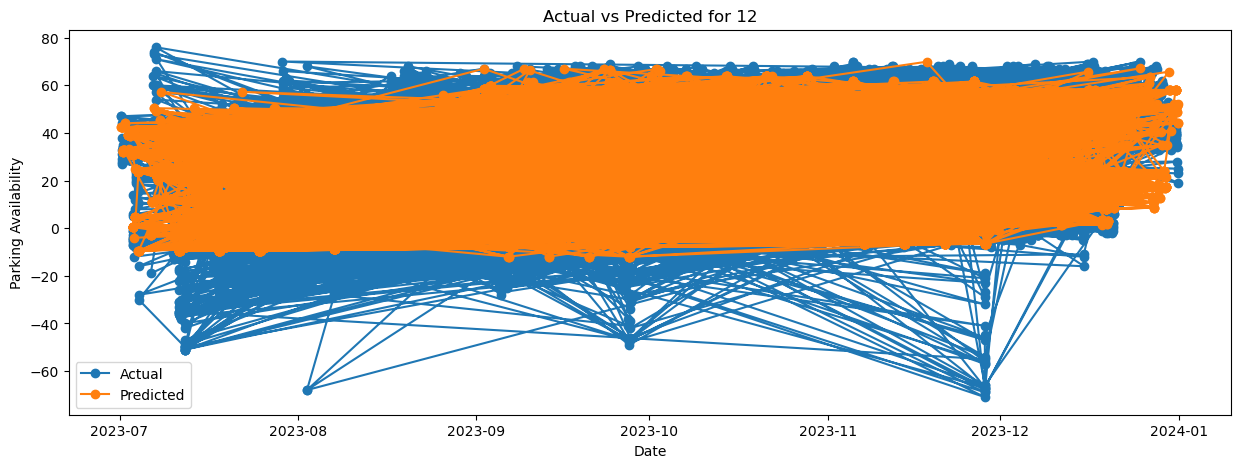

Mean Squared Error for 13: 148.94118882449243
Root Mean Squared Error for 13: 12.20414637836225
Mean Absolute Error for 13: 7.905383263239785


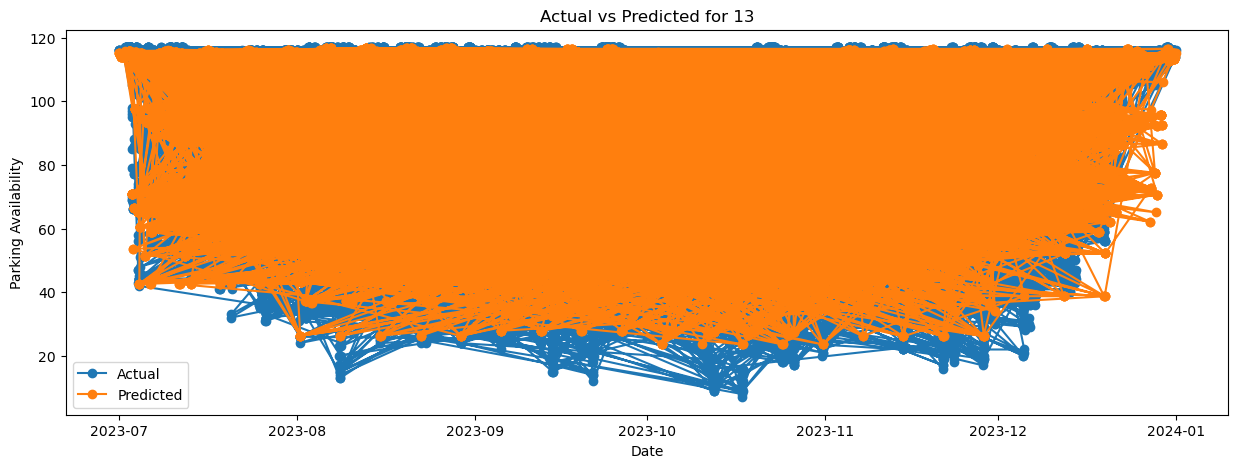

Mean Squared Error for 14: 421.62059087682525
Root Mean Squared Error for 14: 20.533401834007567
Mean Absolute Error for 14: 15.927621380423902


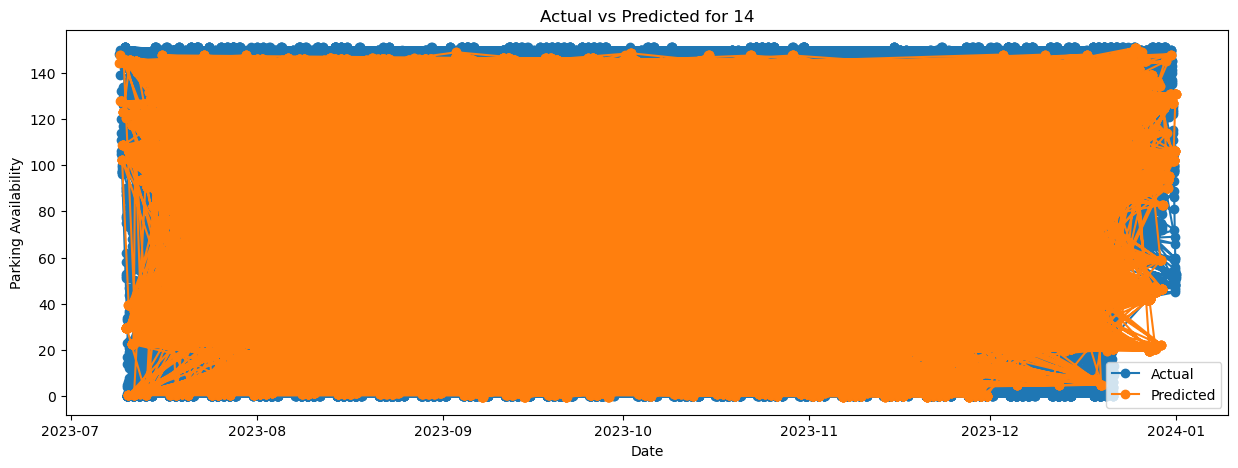

Mean Squared Error for 15: 2306.4370701676858
Root Mean Squared Error for 15: 48.02537943803969
Mean Absolute Error for 15: 38.054255212335136


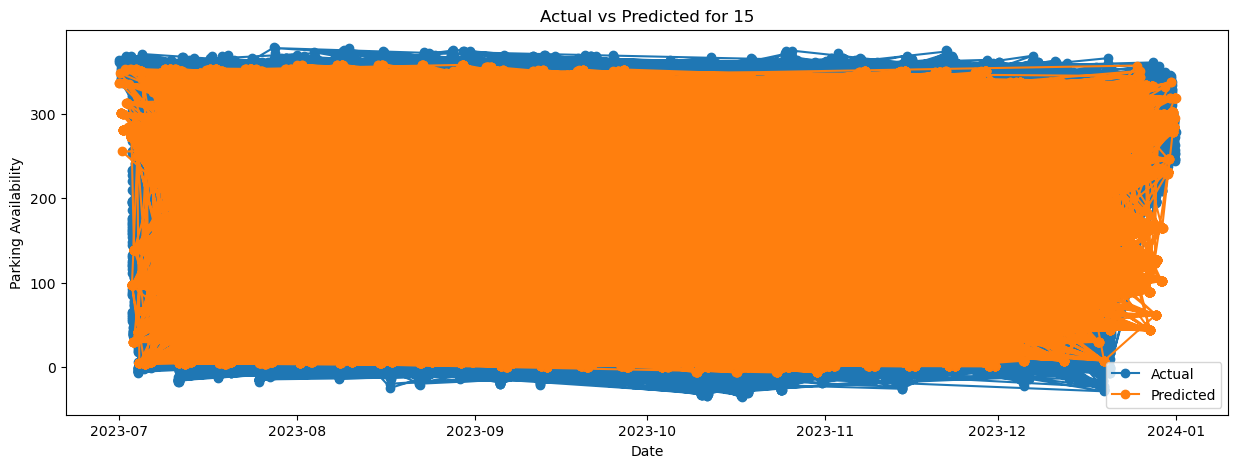

Mean Squared Error for 16: 22826.542901984612
Root Mean Squared Error for 16: 151.08455547138038
Mean Absolute Error for 16: 113.69363805345868


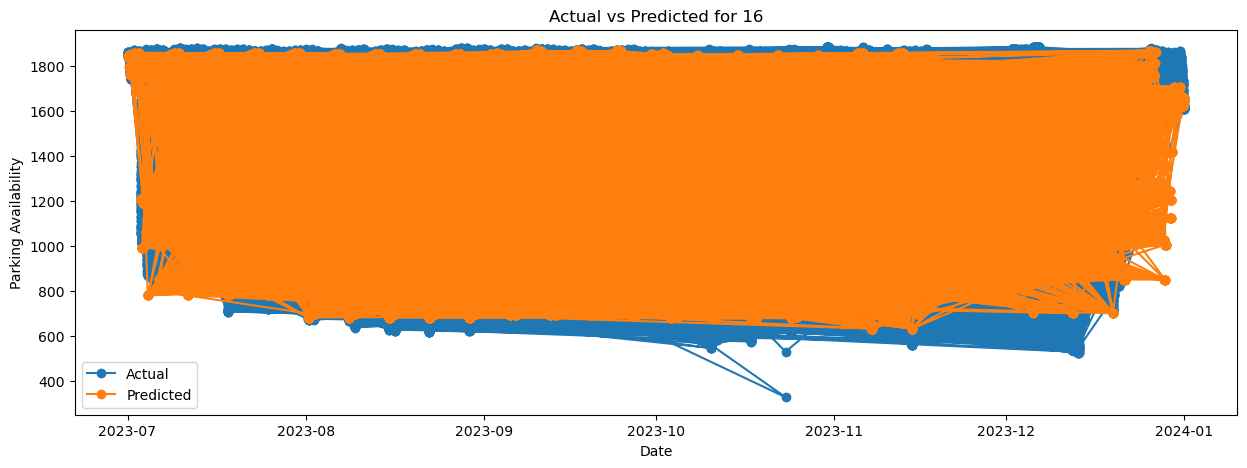

Mean Squared Error for 17: 14820.029510366101
Root Mean Squared Error for 17: 121.73754355319521
Mean Absolute Error for 17: 89.8539544316981


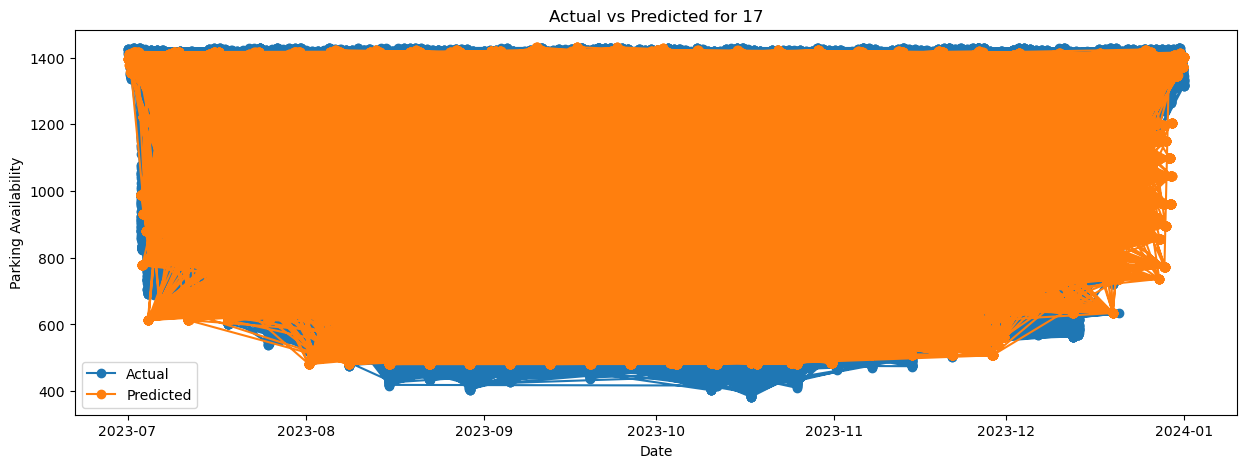

Mean Squared Error for 18: 3572.8875293378997
Root Mean Squared Error for 18: 59.77363573798987
Mean Absolute Error for 18: 46.619987520671906


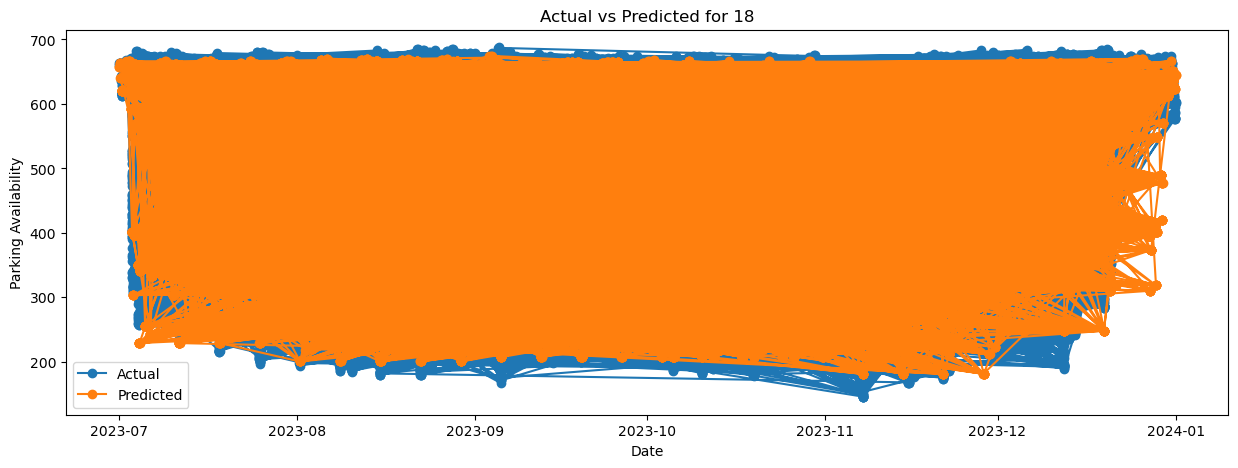

Mean Squared Error for 19: 75.32229028429022
Root Mean Squared Error for 19: 8.678841528930587
Mean Absolute Error for 19: 6.187406167302442


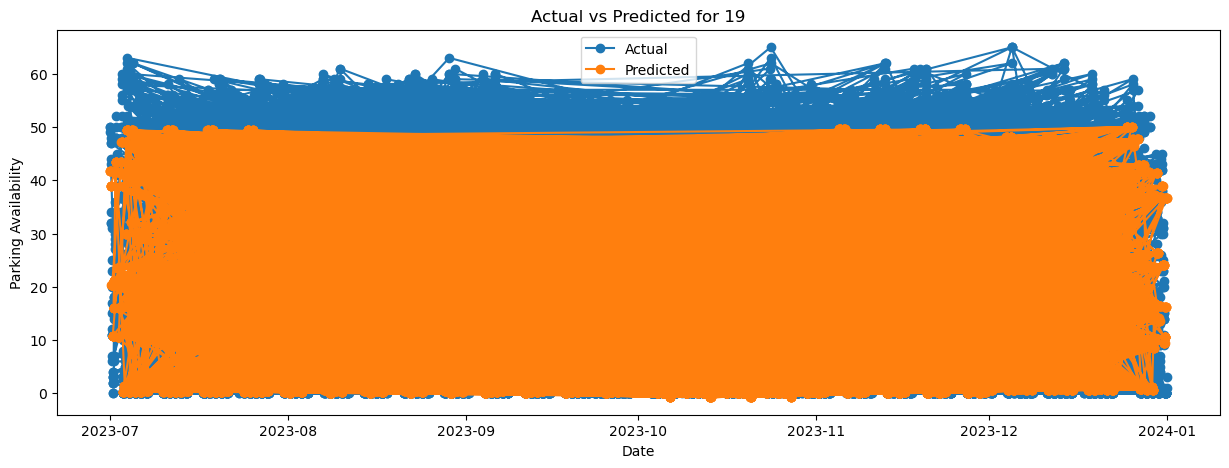

Mean Squared Error for 20: 176.6664713865818
Root Mean Squared Error for 20: 13.291594012253828
Mean Absolute Error for 20: 9.61029505334681


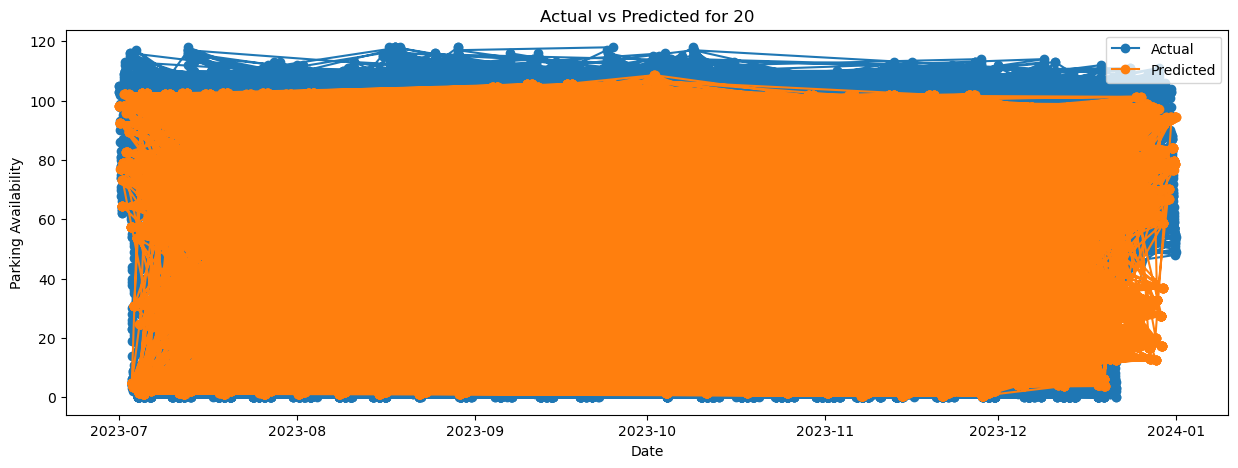

Mean Squared Error for 21: 317.1166604450745
Root Mean Squared Error for 21: 17.80776966509491
Mean Absolute Error for 21: 11.967069021154035


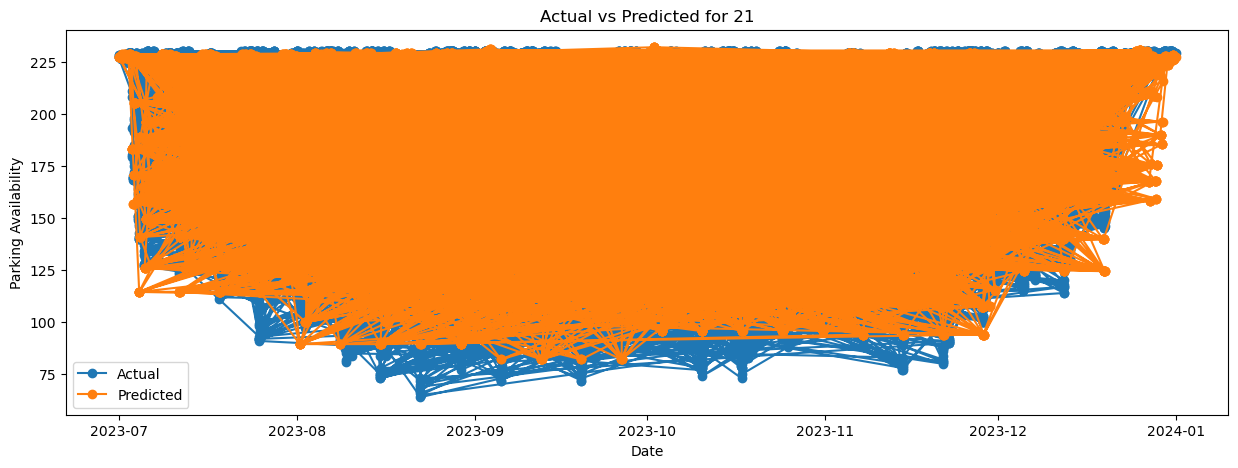

Mean Squared Error for 22: 9202.61852786214
Root Mean Squared Error for 22: 95.93027951518822
Mean Absolute Error for 22: 71.80229099508254


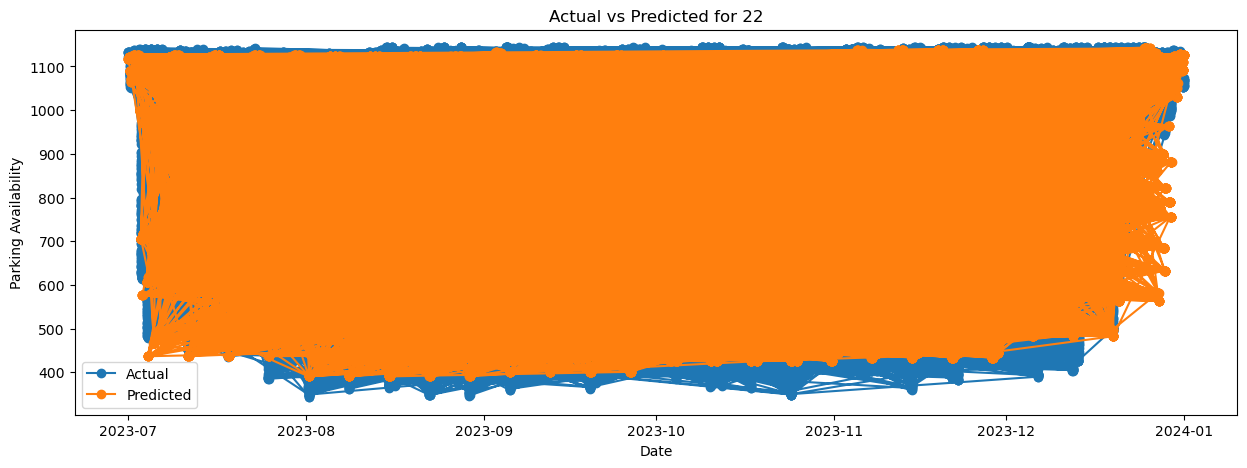

Mean Squared Error for 23: 4944.76491300833
Root Mean Squared Error for 23: 70.319022412206
Mean Absolute Error for 23: 54.57714225517008


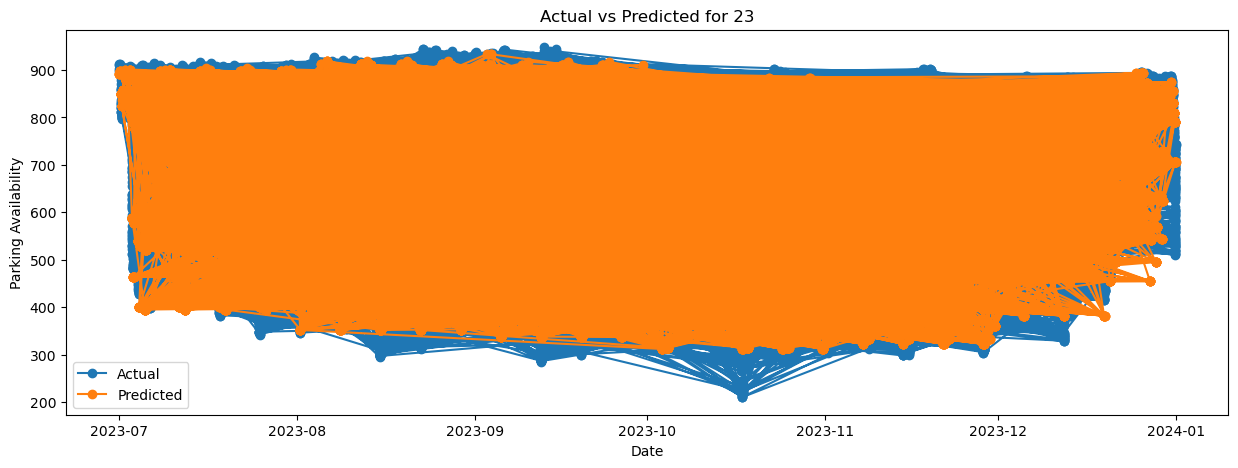

Mean Squared Error for 24: 13008.002027537068
Root Mean Squared Error for 24: 114.05262832366937
Mean Absolute Error for 24: 82.10671212852961


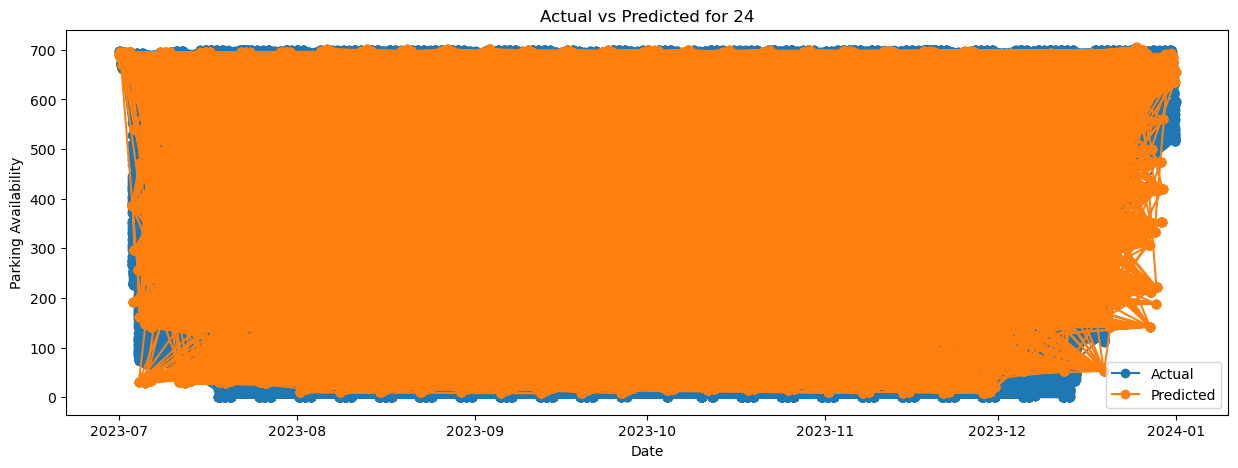

Mean Squared Error for 25: 461.36297185935564
Root Mean Squared Error for 25: 21.47936153286116
Mean Absolute Error for 25: 15.735742885971018


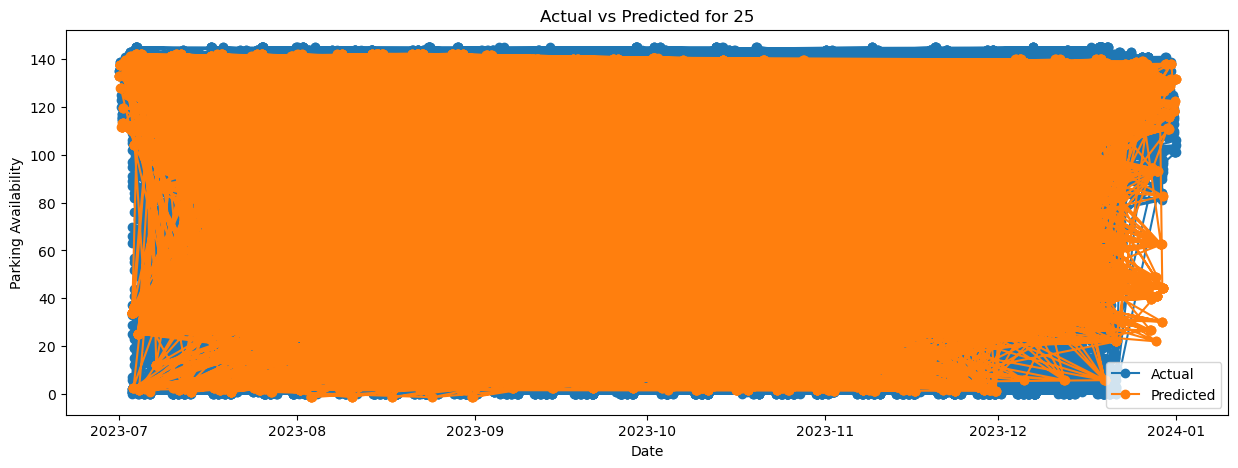

In [66]:
# Dictionary to store XGBoost models for each parking lot
xg_models = {}

# Train a model for each parking lot
for facility_id, group_data in xg_grouped:
    # Split the data into features and target variable
    X = group_data.drop(columns=["parking_availability"], axis=1)
    y = group_data["parking_availability"]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create an XGBoost model
    xg_model = xgb.XGBRegressor(objective='reg:squarederror')

    # Train the model
    xg_model.fit(X_train, y_train)

    # Make predictions on the test set
    # group_data["prediction"] = xg_model.predict(X_test)
    predictions = xg_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    print(f'Mean Squared Error for {facility_id}: {mse}')
    print(f'Root Mean Squared Error for {facility_id}: {rmse}')
    print(f'Mean Absolute Error for {facility_id}: {mae}')
    
    # Store the trained model in the dictionary
    xg_models[facility_id] = xg_model

    # Plot actual vs predicted values
    plt.figure(figsize=(15, 5))
    plt.plot(X_test.index, y_test, label='Actual', marker='o')
    plt.plot(X_test.index, predictions, label='Predicted', marker='o')
    plt.title(f'Actual vs Predicted for {facility_id}')
    plt.xlabel('Date')
    plt.ylabel('Parking Availability')
    plt.legend()
    plt.show()


Hyperparameter tuned model

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = { 
    "learning_rate": [0.01, 0.2],
    "max_depth": [5, 6, 7],
    "gamma": [0.1, 0.2],
    "reg_lambda": [0.01,  0.1],
    "reg_alpha": [0, 0.01, 0.1, 0.2],
    "n_estimators": [30, 50]
}
class XGBoostTimeSeriesModel:
    def __init__(self, param_grid, target_variable='parking_availability', cv=3, n_jobs=-1):
        self.param_grid = param_grid
        self.target_variable = target_variable
        self.cv = cv
        self.n_jobs = n_jobs
        self.models = {}

    def _get_features_target(self, group_data):
        X = group_data.drop(columns=[self.target_variable, "facility_name"], axis=1)
        y = group_data[self.target_variable]
        return X, y

    def train_models(self, xg_grouped):
        for facility_name, group_data in xg_grouped:
            X, y = self._get_features_target(group_data)

            # Create an XGBoost model
            xg_model = xgb.XGBRegressor(objective='reg:squarederror')

            # Perform GridSearchCV
            grid_search = GridSearchCV(xg_model, param_grid=self.param_grid, cv=self.cv, n_jobs=self.n_jobs)
            grid_search.fit(X, y)

            # Get the best hyperparameters
            best_params = grid_search.best_params_
            print(f'Best Hyperparameters for {facility_name}: {best_params}')

            # Use the best model from GridSearchCV
            best_model = grid_search.best_estimator_

            # Train the model
            best_model.fit(X, y)

            # Store the trained model in the dictionary
            self.models[facility_name] = best_model

    def predict_and_plot(self, xg_grouped):
        predictions_df = pd.DataFrame()  # Initialize the DataFrame to store predictions

        for facility_name, model in self.models.items():
            # Get the last available data for each facility
            last_data = xg_grouped.get_group(facility_name).tail(1).drop(columns=["parking_availability"])

            # Make predictions for the next time period
            facility_predictions = model.predict(last_data)

            # Add 'prediction' column to the predictions DataFrame
            predictions_df = pd.concat([predictions_df, pd.DataFrame({
                'facility_name': [facility_name] * len(facility_predictions),
                'prediction': facility_predictions
                })])

        # Merge predictions with the original DataFrame based on the 'facility_name'
        xg_grouped_predictions = pd.merge(xg_grouped, predictions_df, on='facility_name', how='left')

        # Plot actual vs predicted values for each facility
        for facility_name, group_data in xg_grouped_predictions.groupby('facility_name'):
            plt.figure(figsize=(10, 5))
            plt.plot(group_data.index, group_data[self.target_variable], label='Actual', marker='o')
            plt.plot(group_data.index, group_data['prediction'], label='Predicted', marker='o')
            plt.title(f'Actual vs Predicted for {facility_name}')
            plt.xlabel('Date')
            plt.ylabel('Parking Availability')
            plt.legend()
            plt.show()

    
    def predict_and_plot(self, xg_grouped):
        predictions_df = pd.DataFrame()  # Initialize the DataFrame to store predictions

        for facility_name, model in self.models.items():
            # Get the last available data for each facility
            last_data = xg_grouped.get_group(facility_name).tail(1).drop(columns=["parking_availability"])

            # Make predictions for the next time period
            facility_predictions = model.predict(last_data)

            # Add 'prediction' column to the predictions DataFrame
            predictions_df = pd.concat([predictions_df, pd.DataFrame({
                'facility_name': [facility_name] * len(facility_predictions),
                'prediction': facility_predictions
            })])



        # Transform the groupby object to a DataFrame
        xg_grouped_df = xg_grouped.transform('last').reset_index()

        # Merge predictions with the original DataFrame based on the 'facility_name'
        xg_grouped_predictions = pd.merge(xg_grouped_df, predictions_df, on='facility_name', how='left')

        # Plot actual vs predicted values for each facility
        for facility_name, group_data in xg_grouped_predictions.groupby('facility_name'):
            plt.figure(figsize=(10, 5))
            plt.plot(group_data.index, group_data[self.target_variable], label='Actual', marker='o')
            plt.plot(group_data.index, group_data['prediction'], label='Predicted', marker='o')
            plt.title(f'Actual vs Predicted for {facility_name}')
            plt.xlabel('Date')
            plt.ylabel('Parking Availability')
            plt.legend()
            plt.show()
        


# # Example usage:
xg_model = XGBoostTimeSeriesModel(param_grid, target_variable= "parking_availability", cv=3, n_jobs= -1)
xg_model.train_models(xg_grouped)
xg_model.predict_and_plot(xg_grouped)



